In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras import layers, models

import tensorflow as tf

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [4]:
# Copy the kaggle.json to the appropriate location
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riwaj111111","key":"4f87d63a52c5d0f05857576ffd2abe2e"}'}

In [5]:

!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

In [6]:
!kaggle datasets download shaunthesheep/microsoft-catsvsdogs-dataset/ -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/versions/
License(s): other
100% 785M/788M [00:08<00:00, 22.6MB/s]
100% 788M/788M [00:08<00:00, 96.6MB/s]


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
original_data_dir = "/content/PetImages"
output_base_dir = "/content/SplitPetImages"

# Paths for train, validation, and test splits
train_dir = os.path.join(output_base_dir, "train")
valid_dir = os.path.join(output_base_dir, "validation")
test_dir = os.path.join(output_base_dir, "test")

# Create directories for train, validation, and test splits
for split_dir in [train_dir, valid_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Get list of class subdirectories
classes = [d for d in os.listdir(original_data_dir) if os.path.isdir(os.path.join(original_data_dir, d))]

for class_name in classes:
    # Paths for the current class
    class_dir = os.path.join(original_data_dir, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    valid_class_dir = os.path.join(valid_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    # Create class subdirectories
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(valid_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # List all images in the class directory
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Split into train, validation, and test
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
    train_imgs, valid_imgs = train_test_split(train_imgs, test_size=0.125, random_state=42)  # 10% of train+valid

    # Move files to respective directories
    for img in train_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
    for img in valid_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(valid_class_dir, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

print("Dataset split complete!")


Dataset split complete!


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
image_shape = (224, 224)  # Resize all images to 224x224
batch_size = 64  # Batch size for loading data

# Initialize ImageDataGenerator for training/validation and test
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    validation_split=0.125  # 10% out of the 80% data for validation (10/80 = 0.125)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (70% of the total dataset)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    '/content/SplitPetImages/train/',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Specify training subset (70% of total)
)

# Create validation data generator (10% of the total dataset)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    '/content/SplitPetImages/validation/',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation'  # Specify validation subset (10% of total)
)

# Create test data generator (20% of the total dataset)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
    '/content/SplitPetImages/test/',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Training Images:
Found 15311 images belonging to 2 classes.
Validating Images:
Found 312 images belonging to 2 classes.
Test Images:
Found 5002 images belonging to 2 classes.


In [29]:
# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

Training Class Names: ['Cat', 'Dog']
Validation Class Names: ['Cat', 'Dog']
Test Class Names: ['Cat', 'Dog']
Number of Training Classes: 2
Number of Validation Classes: 2
Number of Test Classes: 2


In [30]:
class_names = train_class_names


In [31]:
# 1. Create base model using MobileNet from tf.keras.applications
base_model_mobilenet = tf.keras.applications.MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')


In [32]:
# 2. Freeze the base model initially to retain pre-trained weights
base_model_mobilenet.trainable = False

In [33]:
# 3. Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")


In [34]:
# 4. Create inputs for the model
inputs_mobilenet = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer_mobilenet")


In [35]:
# 5. Apply data augmentation
x_mobilenet = data_augmentation(inputs_mobilenet)

In [36]:
# 6. Pass the inputs through the base model
x_mobilenet = base_model_mobilenet(x_mobilenet)
print(f"Shape after base_model (MobileNet): {x_mobilenet.shape}")  # Check the shape after passing through the base model


Shape after base_model (MobileNet): (None, 7, 7, 1024)


In [37]:
# 7. Add a Global Average Pooling layer
x_mobilenet = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer_mobilenet")(x_mobilenet)
print(f"Shape after GlobalAveragePooling2D() (MobileNet): {x_mobilenet.shape}")


Shape after GlobalAveragePooling2D() (MobileNet): (None, 1024)


In [38]:

# # 8. Add a fully connected (dense) layer
# x_mobilenet = tf.keras.layers.Dense(256, activation='relu', name="dense_layer_mobilenet")(x_mobilenet)


In [39]:
# 9. Add a dropout layer
x_mobilenet = tf.keras.layers.Dropout(0.5, name="dropout_layer_mobilenet")(x_mobilenet)


In [40]:
# 10. Add the output layer for classification
# Adjust the number of units in the Dense layer to match your class count (e.g., 5 for 5 classes)
outputs_mobilenet = tf.keras.layers.Dense(2, activation="softmax", name="output_layer_mobilenet")(x_mobilenet)


In [41]:
# 11. Combine the inputs and outputs into a model
mobilenet_model = tf.keras.Model(inputs_mobilenet, outputs_mobilenet)


In [42]:
mobilenet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_mobilenet (InputLayer)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer_mobile… │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_mobilenet (Dropout)    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer_mobilenet (Dense)       │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,230,914 (12.32 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [43]:
# 12. Compile the model
mobilenet_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [44]:
# 13. Learning rate scheduler
lr_scheduler_mobilenet = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7
)

# 14. Early stopping
early_stopping_mobilenet = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)


In [45]:
# # 15. Unfreeze the last few layers of the base model
# for layer in base_model_mobilenet.layers[-10:]:
#     layer.trainable = True

In [46]:
# 18. Fit the model (adjust epochs and batch size as needed)
history_mobilenet = mobilenet_model.fit(
    train_data,  # Replace with your training dataset
    validation_data=valid_data,  # Replace with your validation dataset
    epochs=15,
    batch_size=64,
    callbacks=[lr_scheduler_mobilenet, early_stopping_mobilenet]
)

Epoch 1/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 221s 884ms/step - accuracy: 0.6159 - loss: 0.7935 - val_accuracy: 0.9455 - val_loss: 0.2991 - learning_rate: 1.0000e-04
Epoch 2/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 208s 846ms/step - accuracy: 0.8117 - loss: 0.4942 - val_accuracy: 0.9455 - val_loss: 0.1871 - learning_rate: 1.0000e-04
Epoch 3/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 207s 841ms/step - accuracy: 0.8688 - loss: 0.3673 - val_accuracy: 0.9583 - val_loss: 0.1548 - learning_rate: 1.0000e-04
Epoch 4/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 229s 926ms/step - accuracy: 0.8852 - loss: 0.3178 - val_accuracy: 0.9679 - val_loss: 0.1317 - learning_rate: 1.0000e-04
Epoch 5/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 243s 855ms/step - accuracy: 0.8949 - loss: 0.2908 - val_accuracy: 0.9551 - val_loss: 0.1147 - learning_rate: 1.0000e-04
Epoch 6/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 206s 838ms/step - accuracy: 0.9058 - loss: 0.2565 - val_accuracy: 0.9712 - val_loss: 0.1086 - learning_rate: 1.0000e-04
Epoch 7/15
240/240 ━━━━━━━━━━━━━━━━━━━━ 

# Removing Corrupt Images

In [27]:
import os
from PIL import Image

def remove_corrupt_images(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Verify if the file is a valid image
            except (IOError, SyntaxError):
                print(f"Removing corrupt image: {file_path}")
                os.remove(file_path)

# Specify your dataset directory
data_dir = "/content/SplitPetImages/"
remove_corrupt_images(data_dir)


Removing corrupt image: /content/SplitPetImages/validation/Cat/666.jpg
Removing corrupt image: /content/SplitPetImages/train/Dog/Thumbs.db
Removing corrupt image: /content/SplitPetImages/train/Dog/11702.jpg
Removing corrupt image: /content/SplitPetImages/train/Cat/Thumbs.db


In [47]:
mobilenet_model.save('mobilenet_model_cats_vs_dogs.keras')


# Training and Evaluation

In [48]:
Y_pred = mobilenet_model.predict(test_data)
score = mobilenet_model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 184ms/step - accuracy: 0.9796 - loss: 0.0628
Test loss: 0.05868842825293541
Test accuracy: 0.983406662940979


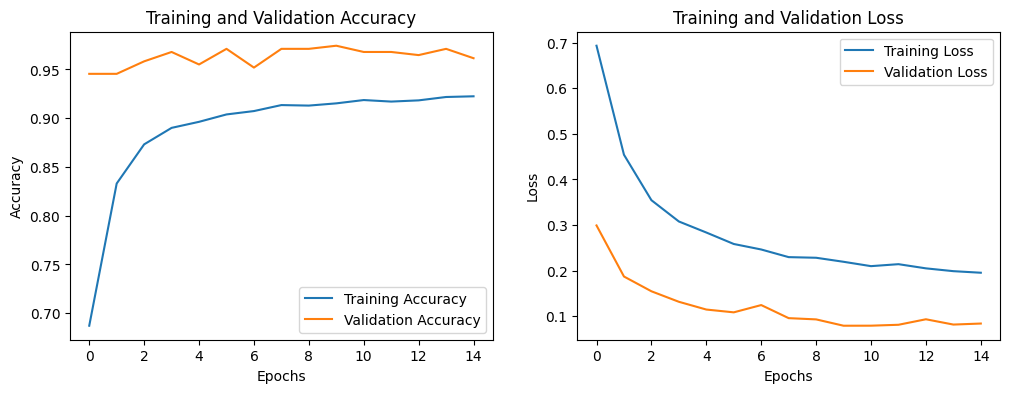

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# Define class names (replace these with actual class names if available)
CLASS_NAMES = class_names

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history_mobilenet)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Classification Report:
               precision    recall  f1-score   support

         Cat       0.97      0.96      0.96       156
         Dog       0.96      0.97      0.96       156

    accuracy                           0.96       312
   macro avg       0.96      0.96      0.96       312
weighted avg       0.96      0.96      0.96       312

Precision: 0.96, Recall: 0.96, F1 Score: 0.96


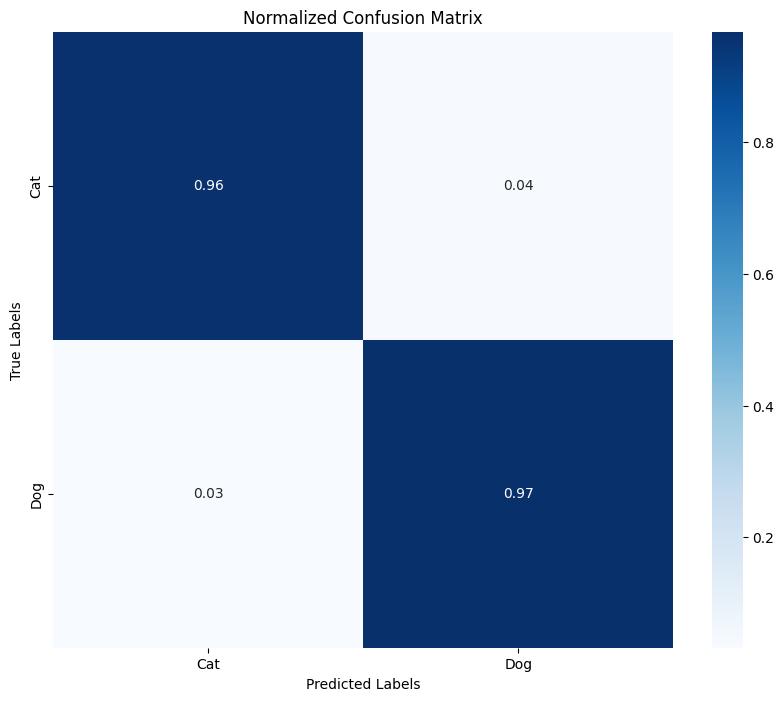

In [50]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predict on validation data
Y_pred = mobilenet_model.predict(valid_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = valid_data.classes  # Actual class labels from validation data

# Generate a classification report
CLASS_NAMES = list(valid_data.class_indices.keys())  # Extract class names from validation data generator
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=class_names))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# GUI Implementation


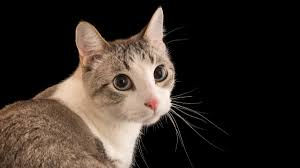

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [51]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import tensorflow as tf

# Load your pre-trained model
model = mobilenet_model  # Assuming your model is already loaded

# Define class names
CLASS_NAMES = class_names  # Use your actual class names here

# Function to preprocess and predict the image
def predict_image(img):
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict and get confidence score
    predictions = model.predict(img_array)
    confidence_scores = predictions[0]
    pred_index = np.argmax(confidence_scores)
    pred_class = class_names[pred_index]
    pred_confidence = confidence_scores[pred_index]

    result_label.value = f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}"

# Define widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
result_label = widgets.Label()

# Display the uploaded image and perform prediction
def on_upload_change(change):
    # Clear previous output (remove old image and result)
    clear_output(wait=True)

    # Re-display the upload button and result label
    display(widgets.VBox([upload_button, result_label]))

    for name, file_info in upload_button.value.items():
        image_data = io.BytesIO(file_info['content'])  # Convert binary content to a BytesIO object
        image = Image.open(image_data)  # Open image with PIL
        display(image)  # Display the uploaded image in the notebook
        predict_image(image)

upload_button.observe(on_upload_change, names='value')

# Display widgets
display(widgets.VBox([upload_button, result_label]))